# Lattice Boltzmann method. Simulation of Poiseuille flow.

In [ ]:
# !mpirun --allow-run-as-root -n 4 python Laba_3.py
# %%writefile Laba_3.py

# import all the needed modules
import numpy as np
import matplotlib.pyplot as plt

# Results of perfomance
To compute perfomance launch time.sh
./time.sh

Text(0.5, 0, 'Speed up')

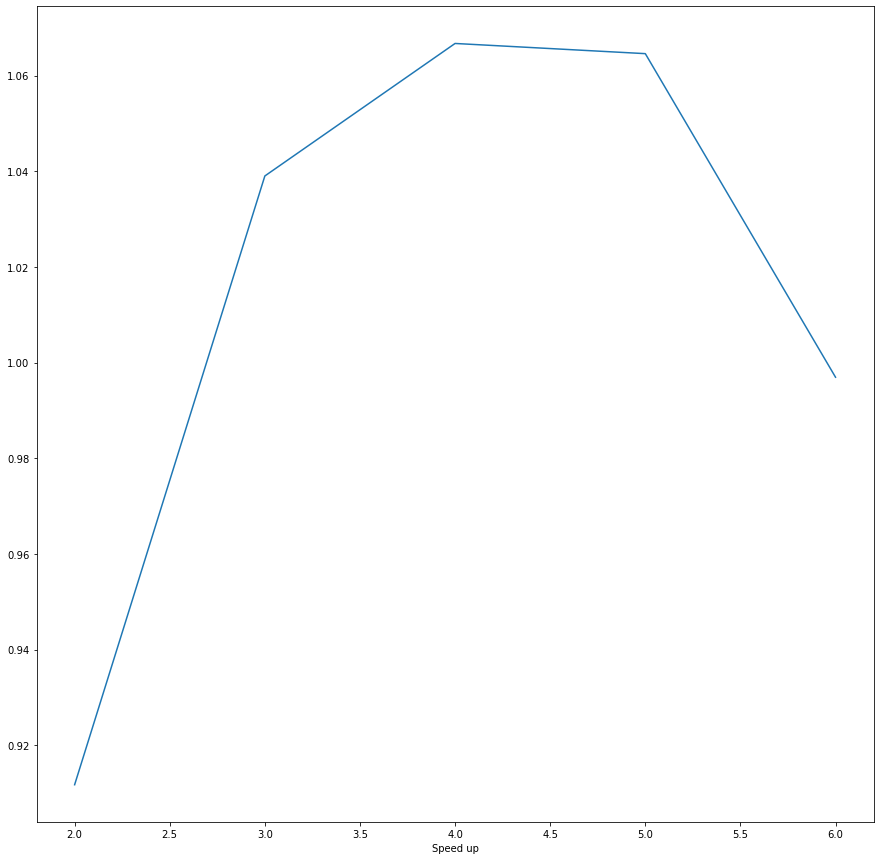

In [8]:
n_num = np.arange(2, 7)
time = 1/(np.array([2*60 + 55.5, 2*60 + 34, 2*60 + 30, 2*60 + 30.3, 2*60 + 40.5])/(2*60+40.01))

plt.figure(figsize=(15,15))
plt.plot(n_num, time)
plt.xlabel('number of CPUs')
plt.xlabel('Speed up')

Initial code

In [ ]:
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

#Simulation parameters
Nx = 100
Ny = 50
rho_in = 1
rho_out = 0.95
tau = 1
e = np.array([[0,0], [1,0], [0,1], [-1,0], [0,-1],
                  [1,1], [-1,1], [-1,-1], [1,-1]])

#Iterative/conv parameters
nt = 5000 # number of time steps
conv_interval = 100
conv_set = np.array([])
epsilon = 0.0001

# calculate equilibrium distribution
def get_feq(rho,u,e):
    feq = np.zeros((Nx,Ny,9))
    for i in range(0,9):
        if (i == 0):
            w = 4.0/9.0
        elif (i<5):
            w = 1.0/9.0
        else:
            w = 1.0/36.0
        eu = u[:,:,0]*e[i,0] + u[:,:,1]*e[i,1]
        feq[:,:,i] = w*rho*(1.0 + 3.0*eu + 4.5*eu**2
                            -1.5*np.sum(u*u, axis = 2))
    return feq

# calculate macroscopic fluid density and velocity
def get_rho_u(f,e):
    rho = np.zeros((Nx,Ny))
    u = np.zeros((Nx,Ny,2))
    for i in range(0,Nx):
        for j in range(0,Ny):
            if (i == 0): # left boundary density
                rho[i,j] = rho_in
            elif (i == Nx-1): # right boundary density
                rho[i,j] = rho_out
            else:
                rho[i,j] = np.sum(f[i,j,:])
            
            
            # upper or lower boundary (u = 0)
            if (j == 0 or j == Ny-1):
                u[i,j,:] = 0.0
            elif (i == 0): # left boundary (u_y = 0)
                u[i,j,0] = 1.0 - (f[i,j,0] + f[i,j,2] + f[i,j,4]
                                  + 2.0*(f[i,j,3] + f[i,j,6]
                                         + f[i,j,7]))/rho_in
                u[i,j,1] = 0.0
            elif (i == Nx-1): # right boundary (u_y = 0)
                u[i,j,0] = -1.0 + (f[i,j,0] + f[i,j,2] + f[i,j,4]
                                  + 2.0*(f[i,j,1] + f[i,j,5]
                                         + f[i,j,8]))/rho_out
                u[i,j,1] = 0.0
            
            else:
                u[i,j,0] = (f[i,j,1] - f[i,j,3] + f[i,j,5]
                           - f[i,j,6] - f[i,j,7] + f[i,j,8])/rho[i,j]
                u[i,j,1] = (f[i,j,2] - f[i,j,4] + f[i,j,5]
                            + f[i,j,6] - f[i,j,7] - f[i,j,8])/rho[i,j]
                
    return rho, u

# streaming and collision step
def streaming_and_collision(f):
    # streaming
    for j in range(Ny-1, 0, -1):
        for i in range(0, Nx-1):
            f[i,j,2] = f[i,j - 1,2]
            f[i,j,6] = f[i + 1,j - 1,6]

    for j in range(Ny-1, 0, -1):
        for i in range(Nx-1, 0, -1):
            f[i,j,1] = f[i - 1,j,1]
            f[i,j,5] = f[i - 1,j - 1,5]

    for j in range(0, Ny-1):
        for i in range(Nx-1, 0, -1):
            f[i,j,4] = f[i,j + 1,4]
            f[i,j,8] = f[i - 1,j + 1,8]

    for j in range(0, Ny-1):
        for i in range(0, Nx-1):
            f[i,j,3] = f[i + 1,j,3]
            f[i,j,7] = f[i + 1,j + 1,7]

    # macroscropic variables
    rho, u = get_rho_u(f,e)
    
    # calc of feq for collision
    feq = get_feq(rho,u,e)
    
    # collision
    f = f - (f - feq)/tau
    
    return f, rho, u

# calculating of boundary values
def boundaries(f):
    # left boundary
    for j in range (1,Ny-1):
        ux = 1.0 - (f[0,j,0] + f[0,j,2] + f[0,j,4]
                    + 2.0*(f[0,j,3] + f[0,j,6] + f[0,j,7]))/rho_in
        f[0,j,1] = f[0,j,3] + 2.0/3.0*rho_in*ux
        f[0,j,5] = f[0,j,7] - 0.5*(f[0,j,2]
                                   - f[0,j,4]) + rho_in*ux/6.0
        f[0,j,8] = f[0,j,6] + 0.5*(f[0,j,2]
                                   - f[0,j,4]) + rho_in*ux/6.0
    # lower boundary
    for i in range (1,Nx-1):
        f[i,0,2] = f[i,0,4]
        f[i,0,5] = f[i,0,7] - 0.5*(f[i,0,1] - f[i,0,3])
        f[i,0,6] = f[i,0,8] + 0.5*(f[i,0,1] - f[i,0,3])
        
    # right boundary
    for j in range (1,Ny-1):
        ux = -1.0 + (f[-1,j,0] + f[-1,j,2] + f[-1,j,4]
                    + 2.0*(f[-1,j,1] + f[-1,j,5]
                           + f[-1,j,8]))/rho_out
        f[-1,j,3] = f[-1,j,1] - 2.0/3.0*rho_out*ux
        f[-1,j,7] = f[-1,j,5] + 0.5*(f[-1,j,2]
                                     - f[-1,j,4]) - rho_out*ux/6.0
        f[-1,j,6] = f[-1,j,8] - 0.5*(f[-1,j,2]
                                     - f[-1,j,4]) - rho_out*ux/6.0
        
    # upper boundary
    for i in range (1,Nx-1):
        f[i,-1,4] = f[i,-1,2]
        f[i,-1,7] = f[i,-1,5] + 0.5*(f[i,-1,1] - f[i,-1,3])
        f[i,-1,8] = f[i,-1,6] - 0.5*(f[i,-1,1] - f[i,-1,3])
        
    # left upper corner
    f[0,-1,1] = f[0,-1,3]
    f[0,-1,4] = f[0,-1,2]
    f[0,-1,8] = f[0,-1,6]
    f[0,-1,5] = 0.5*(rho_in - np.sum(f[0,-1,[0,1,2,3,4,6,8]]))
    f[0,-1,7] = f[0,-1,5]
    
    # left lower corner
    f[0,0,1] = f[0,0,3]
    f[0,0,2] = f[0,0,4]
    f[0,0,5] = f[0,0,7]
    f[0,0,6] = 0.5*(rho_in - np.sum(f[0,0,[0,1,2,3,4,5,7]]))
    f[0,0,8] = f[0,0,6]
    
    # right lower corner
    f[-1,0,2] = f[-1,0,4]
    f[-1,0,3] = f[-1,0,1]
    f[-1,0,6] = f[-1,0,8]
    f[-1,0,5] = 0.5*(rho_out - np.sum(f[-1,0,[0,1,2,3,4,6,8]]))
    f[-1,0,7] = f[-1,0,5]
    
    # right upper corner
    f[-1,-1,3] = f[-1,-1,1]
    f[-1,-1,4] = f[-1,-1,2]
    f[-1,-1,7] = f[-1,-1,5]
    f[-1,-1,6] = 0.5*(rho_out - np.sum(f[-1,-1,[0,1,2,3,4,5,7]]))
    f[-1,-1,8] = f[-1,-1,6]
    
    return f

def has_converged(av_en, conv_interval, epsilon, iT, to_print):
    global conv_set
    if conv_set.shape[0] < conv_interval:
        conv_set = np.append(conv_set, av_en)
        return False
    else:
        conv_set = np.append(conv_set, av_en)
        conv_set = np.delete(conv_set, 0)
        conv_set_av = np.average(conv_set)
        
        dev = np.std(conv_set)
        
        error = np.abs(dev/conv_set_av)
        
        if iT % conv_interval == 0:
            print("Relative error at the iteration {} is:{:.3e}".format(iT, error))
        
        if np.abs(dev/conv_set_av) < epsilon:
            return True  
    
def av_energy(rho, u):
    return 0.5*rho*u**2/3

# set up the lattice
def LBM_execute(to_print=True):

    # initialization
    f = np.zeros((Nx,Ny,9))
    rho = np.ones((Nx,Ny))
    u = np.zeros((Nx,Ny,2))

    
    # initialize the simulation
    f = get_feq(rho, u, e)

    #Iteration loop
    for t in range(0,nt):
        f = boundaries(f)       # we need to stream on boundaries first. Watch closely how exactly we handle with order of BCs.
        f, rho, u = streaming_and_collision(f)        # Stream all the rest nodes

        # convergence check
        average_energy = av_energy(np.mean(rho), np.mean(u[:,:,0]))

        if has_converged(average_energy, conv_interval, epsilon, t, to_print):
            if to_print:
                print("Simulation converged! Final iteration is {}".format(t))
            break
    return rho, u

rho, u = LBM_execute(True)

# %timeit -r 3 -o LBM_execute(False)

# plot the results
print(u.shape)
y = np.arange(0,Ny,1)
ux = [u[Nx//2,j,0] for j in y]
plt.figure(1)
plt.plot(ux,y)
plt.xlabel(r'$y$')
plt.ylabel(r'$u_x(y)$')

plt.figure(2)
plt.imshow(u[:,:,0].T, cmap='coolwarm')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$u_x$')
# plt.savefig("C:/File_Sandbox/Vishnyakov_course/Good.png")

plt.figure(4)
plt.imshow(rho[:,:].T, cmap='coolwarm')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$\rho$')

plt.show()

Parallelized code

In [ ]:
# !mpirun --allow-run-as-root -n 4 python Laba_3.py

# import all the needed modules
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import time

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

comm.Barrier()
# calculate equilibrium distribution
    
def av_energy(rho, u):
    return 0.5*rho*u**2/3

def get_feq(rho,u,e):
    feq = np.zeros((Nx,Ny,9))
    for i in range(0,9):
        if (i == 0):
            w = 4.0/9.0
        elif (i<5):
            w = 1.0/9.0
        else:
            w = 1.0/36.0
        eu = u[:,:,0]*e[i,0] + u[:,:,1]*e[i,1]
        feq[:,:,i] = w*rho*(1.0 + 3.0*eu + 4.5*eu**2
                            -1.5*np.sum(u*u, axis = 2))
    return feq

# calculate macroscopic fluid density and velocity
def get_rho_u(f,e):
    rho = np.zeros((Nx,Ny))
    u = np.zeros((Nx,Ny,2))
    for i in range(0,Nx):
        for j in range(0,Ny):
            if (i == 0): # left boundary density
                rho[i,j] = rho_in
            elif (i == Nx-1): # right boundary density
                rho[i,j] = rho_out
            else:
                rho[i,j] = np.sum(f[i,j,:])
            
            
            # upper or lower boundary (u = 0)
            if (j == 0 or j == Ny-1):
                u[i,j,:] = 0.0
            elif (i == 0): # left boundary (u_y = 0)
                u[i,j,0] = 1.0 - (f[i,j,0] + f[i,j,2] + f[i,j,4]
                                  + 2.0*(f[i,j,3] + f[i,j,6]
                                         + f[i,j,7]))/rho_in
                u[i,j,1] = 0.0
            elif (i == Nx-1): # right boundary (u_y = 0)
                u[i,j,0] = -1.0 + (f[i,j,0] + f[i,j,2] + f[i,j,4]
                                  + 2.0*(f[i,j,1] + f[i,j,5]
                                         + f[i,j,8]))/rho_out
                u[i,j,1] = 0.0
            
            else:
                u[i,j,0] = (f[i,j,1] - f[i,j,3] + f[i,j,5]
                           - f[i,j,6] - f[i,j,7] + f[i,j,8])/rho[i,j]
                u[i,j,1] = (f[i,j,2] - f[i,j,4] + f[i,j,5]
                            + f[i,j,6] - f[i,j,7] - f[i,j,8])/rho[i,j]
                
    return rho, u

# streaming and collision step
def streaming_and_collision(f):
    # streaming
    step = (Ny-1) // (size - 1)
    min_j = step*rank
    max_j = step*(rank+1)
    if (rank == size - 2) and (rank < size - 1):
        max_j = Ny-1

    if (rank < size - 1): # procces with CPU0-CPU3
        for j in range(max_j, min_j, -1):
            for i in range(0, Nx-1):
                f[i,j,2] = f[i,j - 1,2]
                f[i,j,6] = f[i + 1,j - 1,6]

        # send f[:,j,k] where j = (min_j, max_j]
        data_tx = [ f[:,min_j+1:max_j+1,2] , f[:,min_j+1:max_j+1,6] ]
        comm.send(data_tx, dest=size-1, tag=rank)
    else:
        for i in range(size - 1):
            status = MPI.Status()
            data_rx = comm.recv(status=status)
            min_j = step*status.Get_source()
            max_j = step*(status.Get_source() + 1)
            if (status.Get_source() == size - 2):
                max_j = Ny-1
            f[:,min_j+1:max_j+1,2] = data_rx[0]
            f[:,min_j+1:max_j+1,6] = data_rx[1]

    comm.Barrier()

    if (rank < size - 1): # procces with CPU0-CPU3
        for j in range(max_j, min_j, -1):
            for i in range(Nx-1, 0, -1):
                f[i,j,1] = f[i - 1,j,1]
                f[i,j,5] = f[i - 1,j - 1,5]

        # send f[:,j,k] where j = (min_j, max_j]
        data_tx = [ f[:,min_j+1:max_j+1,1] , f[:,min_j+1:max_j+1,5] ]
        comm.send(data_tx, dest=size-1, tag=rank)
    else:
        for i in range(size - 1):
            status = MPI.Status()
            data_rx = comm.recv(status=status)
            min_j = step*status.Get_source()
            max_j = step*(status.Get_source() + 1)
            if (status.Get_source() == size - 2):
                max_j = Ny-1
            f[:,min_j+1:max_j+1,1] = data_rx[0]
            f[:,min_j+1:max_j+1,5] = data_rx[1]

    comm.Barrier()

    if (rank < size - 1): # procces with CPU0-CPU3
        for j in range(min_j, max_j):
            for i in range(Nx-1, 0, -1):
                f[i,j,4] = f[i,j + 1,4]
                f[i,j,8] = f[i - 1,j + 1,8]

        # send f[:,j,k] where j = [min_j, max_j)
        data_tx = [ f[:,min_j:max_j,4] , f[:,min_j:max_j,8] ]
        comm.send(data_tx, dest=size-1, tag=rank)
    else:
        for i in range(size - 1):
            status = MPI.Status()
            data_rx = comm.recv(status=status)
            min_j = step*status.Get_source()
            max_j = step*(status.Get_source() + 1)
            if (status.Get_source() == size - 2):
                max_j = Ny-1
            f[:,min_j:max_j,4] = data_rx[0]
            f[:,min_j:max_j,8] = data_rx[1]

    comm.Barrier()

    if (rank < size - 1): # procces with CPU0-CPU3
        for j in range(min_j, max_j):
            for i in range(0, Nx-1):
                f[i,j,3] = f[i + 1,j,3]
                f[i,j,7] = f[i + 1,j + 1,7]

        # send f[:,j,k] where j = [min_j, max_j)
        data_tx = [ f[:,min_j:max_j,3] , f[:,min_j:max_j,7] ]
        comm.send(data_tx, dest=size-1, tag=rank)
    else:
        for i in range(size - 1):
            status = MPI.Status()
            data_rx = comm.recv(status=status)
            min_j = step*status.Get_tag()
            max_j = step*(status.Get_tag() + 1)
            if (status.Get_tag() == size - 2):
                max_j = Ny-1
            f[:,min_j:max_j,3] = data_rx[0]
            f[:,min_j:max_j,7] = data_rx[1]

    comm.Barrier()
    
    # Sync f from CPU4 to CPU0 - CPU3
    if (rank == size - 1):
        data_tx = f
        for i in range(size - 1): # from CPU0 to CPUn, n = size - 1 (including)
            comm.send(data_tx, dest=i)
    else:
        data_rx = data_rx = comm.recv(source=size-1)
        f = data_rx

    comm.Barrier()

    # macroscropic variables
    rho, u = get_rho_u(f,e)
    
    # calc of feq for collision
    feq = get_feq(rho,u,e)
    
    # collision
    f = f - (f - feq)/tau
    
    return f, rho, u


# calculating of boundary values
def boundaries(f):
    # left boundary
    for j in range (1,Ny-1):
        if (rank == j % (size - 1) ):   # calculate between CPU0 - CPU3
            ux = 1.0 - (f[0,j,0] + f[0,j,2] + f[0,j,4] + 2.0*(f[0,j,3] + f[0,j,6] + f[0,j,7]))/rho_in
            
            f[0,j,1] = f[0,j,3] + 2.0/3.0*rho_in*ux
            f[0,j,5] = f[0,j,7] - 0.5*(f[0,j,2] - f[0,j,4]) + rho_in*ux/6.0
            f[0,j,8] = f[0,j,6] + 0.5*(f[0,j,2] - f[0,j,4]) + rho_in*ux/6.0
            
            if (rank < size - 1):   # send to CPU4
                data_tx = [ f[0,j,1], f[0,j,5], f[0,j,8] ]
                comm.send(data_tx, dest=size - 1, tag=j)

        elif (rank == size - 1):    # receive from CPUn taged
            status = MPI.Status()
            data_rx = comm.recv(status=status)
            row = status.Get_tag()
            f[0, row, 1] = data_rx[0]
            f[0, row, 5] = data_rx[1]
            f[0, row, 8] = data_rx[2]
    
    comm.Barrier()  # Wait for all
    # No needs to sync f from CPU4 to others CPUn j = [1 : Ny - 1)

    # lower boundary
    for i in range (1,Nx-1):
        if (rank == i % (size - 1) ):   # calculate between CPU0 - CPU3
            f[i,0,2] = f[i,0,4]
            f[i,0,5] = f[i,0,7] - 0.5*(f[i,0,1] - f[i,0,3])
            f[i,0,6] = f[i,0,8] + 0.5*(f[i,0,1] - f[i,0,3])

            if (rank < size - 1):   # send to CPU4
                data_tx = [ f[i,0,2], f[i,0,5], f[i,0,6] ]
                comm.send(data_tx, dest=size - 1, tag=i)

        elif (rank == size - 1):    # receive from CPUn taged
                    status = MPI.Status()
                    data_rx = comm.recv(status=status)
                    row = status.Get_tag()
                    f[row, 0, 2] = data_rx[0]
                    f[row, 0, 5] = data_rx[1]
                    f[row, 0, 8] = data_rx[2]
        
    comm.Barrier()  # Wait for all
    # Sync f from CPU4 to CPU0 - CPU3
    if (rank == size - 1):
        data_tx = f
        for i in range(size - 1): # from CPU0 to CPUn, n = size - 1 (including)
            comm.send(data_tx, dest=i)
    else:
        data_rx = data_rx = comm.recv(source=size-1)
        f = data_rx

    # right boundary
    for j in range (1,Ny-1):
        if (rank == j % (size - 1) ):   # calculate between CPU0 - CPU3
            ux = -1.0 + (f[-1,j,0] + f[-1,j,2] + f[-1,j,4] + 2.0*(f[-1,j,1] + f[-1,j,5] + f[-1,j,8]))/rho_out

            f[-1,j,3] = f[-1,j,1] - 2.0/3.0*rho_out*ux
            f[-1,j,7] = f[-1,j,5] + 0.5*(f[-1,j,2] - f[-1,j,4]) - rho_out*ux/6.0
            f[-1,j,6] = f[-1,j,8] - 0.5*(f[-1,j,2] - f[-1,j,4]) - rho_out*ux/6.0
        
            if (rank < size - 1):   # send to CPU4
                data_tx = [ f[-1,j,3], f[-1,j,7], f[-1,j,6] ]
                comm.send(data_tx, dest=size - 1, tag=j)

        elif (rank == size - 1):    # receive from CPUn taged
            status = MPI.Status()
            data_rx = comm.recv(status=status)
            row = status.Get_tag()
            f[-1, row, 3] = data_rx[0]
            f[-1, row, 7] = data_rx[1]
            f[-1, row, 6] = data_rx[2]

    comm.Barrier()  # Wait for all

    # upper boundary
    for i in range (1,Nx-1):
        if (rank == i % (size - 1) ):   # calculate between CPU0 - CPU3
            f[i,-1,4] = f[i,-1,2]
            f[i,-1,7] = f[i,-1,5] + 0.5*(f[i,-1,1] - f[i,-1,3])
            f[i,-1,8] = f[i,-1,6] - 0.5*(f[i,-1,1] - f[i,-1,3])
        
            if (rank < size - 1):   # send to CPU4
                data_tx = [ f[i,-1,4], f[i,-1,7], f[i,-1,8] ]
                comm.send(data_tx, dest=size - 1, tag=i)

        elif (rank == size - 1):    # receive from CPUn taged
                    status = MPI.Status()
                    data_rx = comm.recv(status=status)
                    row = status.Get_tag()
                    f[row, -1, 4] = data_rx[0]
                    f[row, -1, 7] = data_rx[1]
                    f[row, -1, 8] = data_rx[2]

    comm.Barrier()  # Wait for all
    # Sync f from CPU4 to CPU0 - CPU3
    if (rank == size - 1):
        data_tx = f
        for i in range(size - 1): # from CPU0 to CPUn, n = size - 1 (including)
            comm.send(data_tx, dest=i)
    else:
        data_rx = data_rx = comm.recv(source=size-1)
        f = data_rx
    
    # left upper corner
    f[0,-1,1] = f[0,-1,3]
    f[0,-1,4] = f[0,-1,2]
    f[0,-1,8] = f[0,-1,6]
    f[0,-1,5] = 0.5*(rho_in - np.sum(f[0,-1,[0,1,2,3,4,6,8]]))
    f[0,-1,7] = f[0,-1,5]
    
    # left lower corner
    f[0,0,1] = f[0,0,3]
    f[0,0,2] = f[0,0,4]
    f[0,0,5] = f[0,0,7]
    f[0,0,6] = 0.5*(rho_in - np.sum(f[0,0,[0,1,2,3,4,5,7]]))
    f[0,0,8] = f[0,0,6]
    
    # right lower corner
    f[-1,0,2] = f[-1,0,4]
    f[-1,0,3] = f[-1,0,1]
    f[-1,0,6] = f[-1,0,8]
    f[-1,0,5] = 0.5*(rho_out - np.sum(f[-1,0,[0,1,2,3,4,6,8]]))
    f[-1,0,7] = f[-1,0,5]
    
    # right upper corner
    f[-1,-1,3] = f[-1,-1,1]
    f[-1,-1,4] = f[-1,-1,2]
    f[-1,-1,7] = f[-1,-1,5]
    f[-1,-1,6] = 0.5*(rho_out - np.sum(f[-1,-1,[0,1,2,3,4,5,7]]))
    f[-1,-1,8] = f[-1,-1,6]
    
    return f

def has_converged(av_en, conv_interval, epsilon, iT, to_print):
    global conv_set
    if conv_set.shape[0] < conv_interval:
        conv_set = np.append(conv_set, av_en)
        return False
    else:
        conv_set = np.append(conv_set, av_en)
        conv_set = np.delete(conv_set, 0)
        conv_set_av = np.average(conv_set)
        
        dev = np.std(conv_set)
        
        error = np.abs(dev/conv_set_av)
        
        if iT % conv_interval == 0 and rank == size - 1:
            print("Relative error at the iteration {} is:{:.3e}".format(iT, error))
        
        if np.abs(dev/conv_set_av) < epsilon:
            return True
        
#Simulation parameters
Nx = 100
Ny = 50
rho_in = 1
rho_out = 0.95
tau = 1
e = np.array([[0,0], [1,0], [0,1], [-1,0], [0,-1],
                  [1,1], [-1,1], [-1,-1], [1,-1]])

#Iterative/conv parameters
nt = 5000 # number of time steps
conv_interval = 100
conv_set = np.array([])
epsilon = 0.0001

# set up the lattice
def LBM_execute(to_print=True):

    # initialization
    f = np.zeros((Nx,Ny,9))
    rho = np.ones((Nx,Ny))
    u = np.zeros((Nx,Ny,2))

    
    # initialize the simulation
    f = get_feq(rho, u, e)

    #Iteration loop
    for t in range(0,nt):
        f = boundaries(f)       # we need to stream on boundaries first. Watch closely how exactly we handle with order of BCs.
        f, rho, u = streaming_and_collision(f)        # Stream all the rest nodes

        # convergence check
        average_energy = av_energy(np.mean(rho), np.mean(u[:,:,0]))

        if has_converged(average_energy, conv_interval, epsilon, t, to_print):
            if to_print:
                print("Simulation converged! Final iteration is {}".format(t))
            break
    return rho, u

# LBM_execute()

rho, u = LBM_execute(True)

# plot the results
if rank == size - 1:
    print(u.shape)
    y = np.arange(0,Ny,1)
    ux = [u[Nx//2,j,0] for j in y]
    plt.figure(1)
    plt.plot(ux,y)
    plt.xlabel(r'$y$')
    plt.ylabel(r'$u_x(y)$')

    plt.figure(2)
    plt.imshow(u[:,:,0].T, cmap='coolwarm')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.title(r'$u_x$')
    # plt.savefig("C:/File_Sandbox/Vishnyakov_course/Good.png")

    plt.figure(4)
    plt.imshow(rho[:,:].T, cmap='coolwarm')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.title(r'$\rho$')

    plt.show()
comm.Barrier()